### Training an Image Classifier 
The following code has been adapted from various sources including: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-3-CNNs-and-image-classification/train-image-classifier-from-pretrained.ipynbdebugged andareas have been debugged using GPT.
In this notebook I clean my image dataset, create new data points for each image and implement these changes back into my 'emtional-class-datasheet.csv'. 
ResNet and VisionTransformer have been implemented for training.

In [1]:
#Installation commands
#%pip install pandas opencv-python torch torchvision efficientnet_pytorch numpy matplotlib pytesseract scikit-learn dlib cmake seaborn
#%pip uninstall opencv-python opencv-python-headless
#%pip install keras
#%pip install tensorflow

# Standard Libraries
import os
import sys
import dlib
import shutil
import time

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.activations import swish # used as opposed to ReLu function for EfficientNetB0 

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

sys.setrecursionlimit(1500)
# Double check my class datasets are recognised:
os.listdir('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset')

import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

['neutral-face', 'happy-face', 'sad-face', 'angry-face']

### Data Pre-Processing
-  Remove any duplicates in 'my-classification-dataset' 
I had noticed a few duplicates when woorking with the same custom dataset for another data science module for k-means cluster experimentation. The private repository can be found here: https://git.arts.ac.uk/23002156/Intro-Data-Science-Portfolio-2024.
-  Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
I could exclude images with text using a text detector, but this may reduce the dataset significantly.
Use Haar Cascade classifier ( which uses feature based object detection) available from: https://github.com/opencv/opencv/tree/4.x/data/haarcascades.
- Create 'emotional-class-datasheet.csv', considering any new changes


In [13]:
# The following code has been adapted from Week 4,Sensing bodies : https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/commit/981594f418f30d02fcff4998cc93f39d4108b608 and debugged using GPT
# Isolate faces using Haar Casscade Classifier, I learnt how to implement this classifier from: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php

# Initialize the face cascade and shape predictor
# Provide the direct path to the Haar cascade XML file
face_cascade = cv2.CascadeClassifier('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/haar/haarcascade_frontalface_alt2.xml')

predictor_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

# Path to the directory containing your images
directory_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'

data = []

# Iterate over all files in the directory, as adapted from: https://www.slingacademy.com/article/python-how-to-iterate-over-all-files-in-a-directory/
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
            # Build the full file path
            image_path = os.path.join(root, filename)
            print("Processing image:", image_path)
            
            # Load the image
            image = cv2.imread(image_path)
            
            # Check if the image was loaded properly
            if image is None:
                print(f"Error loading image {image_path}. Skipping...")
                continue

            # Convert the image to grayscale for feature extraction, which helps to reduce any noise when the images are processed and hopefully better training.
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # If no faces are detected
            if len(faces) == 0:
                print("No faces detected in", image_path)
                # Remove the file from the directory
                os.remove(image_path)
                print(image_path, "removed from dataset")
                continue

            # Extract emotion class from the directory path
            emotion_class = os.path.basename(root)

             # Next I need to find eye, mouth and nose landmark points for each image. I started with creating variables to store the data.
            # Code debugged  using GPT and adapted from https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-4-Sensing-bodies and https://dontrepeatyourself.org/post/how-to-detect-face-landmarks-with-dlib-python-and-opencv/?utm_content=cmp-true
            for (x, y, w, h) in faces:
                face_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
                landmarks = predictor(gray, face_rect)

                # Initialize lists for landmarks
                eyes_x, eyes_y, nose_x, nose_y, mouth_x, mouth_y = [], [], [], [], [], []
                left_eyebrow_x, left_eyebrow_y = [], []
                right_eyebrow_x, right_eyebrow_y = [], []

                # Extract landmark coordinates for eyes
                for n in range(36, 48):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    eyes_x.append(x)
                    eyes_y.append(y)

                # Extract landmark coordinates for nose
                for n in range(27, 35):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    nose_x.append(x)
                    nose_y.append(y)

                # Extract landmark coordinates for mouth
                for n in range(48, 68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    mouth_x.append(x)
                    mouth_y.append(y)

                # Extract landmark coordinates for eyebrows
                for n in range(17, 22):  # Right eyebrow
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    right_eyebrow_x.append(x)
                    right_eyebrow_y.append(y)

                for n in range(22, 27):  # Left eyebrow
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    left_eyebrow_x.append(x)
                    left_eyebrow_y.append(y)

                  # Calculate eyebrow angles
                left_angle = np.arctan2(left_eyebrow_y[0] - left_eyebrow_y[3], left_eyebrow_x[0] - left_eyebrow_x[3]) * (180 / np.pi)
                right_angle = np.arctan2(right_eyebrow_y[0] - right_eyebrow_y[3], right_eyebrow_x[0] - right_eyebrow_x[3]) * (180 / np.pi)

                # Calculate inter-eyebrow distance (distance between midpoints of the left and right eyebrows)
                eyebrow_distance = np.sqrt((right_eyebrow_x[2] - left_eyebrow_x[2]) ** 2 + (right_eyebrow_y[2] - left_eyebrow_y[2]) ** 2)

                # Append extracted features to the list
                data.append({
                    'Image': filename, 
                    'EmotionClass': emotion_class, 
                    'TotalFaceArea': w * h,
                    'EyesX': eyes_x, 
                    'EyesY': eyes_y, 
                    'NoseX': nose_x, 
                    'NoseY': nose_y,
                    'MouthX': mouth_x, 
                    'MouthY': mouth_y,
                    'LeftEyebrowX': left_eyebrow_x,  # Adding eyebrow X coordinates
                    'LeftEyebrowY': left_eyebrow_y,  # Adding eyebrow Y coordinates
                    'RightEyebrowX': right_eyebrow_x,  # Adding eyebrow X coordinates
                    'RightEyebrowY': right_eyebrow_y,  # Adding eyebrow Y coordinates
                    'LeftEyebrowAngle': left_angle,
                    'RightEyebrowAngle': right_angle,
                    'EyebrowDistance': eyebrow_distance })
                

# Create a DataFrame to store the data
df = pd.DataFrame(data)

# Write the data to a CSV file
df.to_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_data.csv', index=False)

# Indicate that processing is complete
print("Data processing complete.")

Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_370491506865098460.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655987.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655978.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_31806741112770968.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002237.210_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655950.jpg
Processing image: /Users/nixi/D

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655617.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_6122149473129917.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655603.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_92534967342949741.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_97320041937333782.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000026.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986321.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1125968642147614.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655825.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3729612240977478.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655986.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_299630181453067042.jpg
Processing image: /Users/nixi/Desktop/Fin

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1407443628430522.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_359232507787505599.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_119134352637236918.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_539657967902865008.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986322.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986444.jpg
Processing image: /Users/nixi/Desktop/Fi

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_406449935090096536.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_147704062764392179.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_443182419602674431.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_22588435626260645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1006202741739729995.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_19562579611135213.jpg
Processing image: /Users/nixi/Desktop/Fin

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986430.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_161003755421340538.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000078.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986197.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986424.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_90635011241421336.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_880453795882149799.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_315955730082893988.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986426.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_15973773668459195.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986354.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000052.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/

libpng warning: iCCP: known incorrect sRGB profile


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-05T231441.912_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986386.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/2336502022_33475bb219_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986379.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_12947917671703612.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000057.png
Processing image: /Users/nixi/Desktop/Final-thesis-fol

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655922.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655936.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002008.009_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751656032.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_951033646304839238.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_570338740311000283.png
Processing image: /Users/nixi/

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000069.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_19914423346149273.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_15199717488061676.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000041.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655894.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986186.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_489696159502381678.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003038.817_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000058.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_659214464236926919.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_129971139239307135.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655641.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-fol

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_65935582036653383.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_602215781439846568.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1077415910847894100.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986388.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_28358672649615636.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_56998751521008358.jpg
Processing image: /Users/nixi/Desktop/Fin

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_115967759147805878.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_27373510229639307.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655695.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3659243437933905.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_4503668371894745.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_54676582949284163.jpg
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655871.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_13651605104165851.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655864.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_207728601556170946.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_16888567431902409.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_75646468732444007.jpg
Processing image: /Users/nixi/Desktop/Fin

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000072.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_618189486373248049.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000066.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_21321798219088645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986374.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986406.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-2

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_365706432218119011.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_55943220344344313.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_909938299705021705.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_703756187362095.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_246712885830603527.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986207.jpg
Processing image: /Users/nixi/Desktop/Final

libpng warning: iCCP: known incorrect sRGB profile


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_297026537932332831.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986373.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_206110120440350676.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000061.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000075.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_325385141819633087.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-2

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_211174967358317.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655692.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003431.096_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3237030973936278.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751655645.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000048.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-

libpng warning: iCCP: known incorrect sRGB profile


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002909.888_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986158.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002417.276_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T002433.507_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_133841420169769226.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_353040058305786315.jpg
Processing image: 

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/000028.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/27533552321_027ee9ca8e_n_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_180355160061033841.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_2322237301177320.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_68747861412.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1407443619132982.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Medi

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_3940718406171112.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514745986448.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/images - 2020-11-06T003037.275_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751656106.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_1105774514751656112.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/neutral-face/pinterest_80290805845656508.jpg
Processing image: /Users/nixi/Des

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_569494315351356831.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253069693496.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/364961554_995f805895_b_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253086036981.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352438544542.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/000033.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-p

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/images - 2020-11-06T000332.733_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352434484842.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071957871.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352441127812.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_371406300532270293.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_348325352441072191.jpg
Processing image: /Users/nixi/Desktop/Final-t

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/000040.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/000054.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_43136108914764385.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/000068.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253071829071.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253091264369.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/happy-face/pinterest_189151253070148038.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954848096570.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images (66)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_213709944804842420.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S137_005_00000026.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000152.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-d

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_25121710416469499.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1970393579944384.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000073.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S014_002_00000014.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000067.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S093_001_00000018.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000098.jpg

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T002114.703_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195149.361_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/S125_001_00000014.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_1105774514752173548.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000310.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954853847557.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000075.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/images - 2020-11-06T195818.739_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/000049.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954856264030.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/2Q__ (7)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sad-face/pinterest_319051954847113569.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/sa

libpng warning: iCCP: known incorrect sRGB profile


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T000443.496_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_140806232226877.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_37928821857266150.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_361906520071480112.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images (25)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751987088.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S109_003_00000017.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S082_005_00000017.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000212.png
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000212.png
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000212.png removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S082_005_00000016.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T

libpng warning: iCCP: known incorrect sRGB profile


No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000207.jpg
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000207.jpg removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000213.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images - 2020-11-06T003650.711_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_932456297835319036.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/pinterest_1105774514751986920.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classificatio

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000200.jpg
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000200.jpg removed from dataset
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/images (14)_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/S042_004_00000019.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000214.jpg
No faces detected in /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000214.jpg
/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset/angry-face/000214.jpg removed from dataset
Processing imag

-  Additional images derrived from https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=anger to ensure the ratio of images for each emotional class ,after cleaning, is over 1000 at the least.This aids in removing bias and better overall classification.

In [2]:
# How has this impacted my ratio?
emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

dirrectory = "/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset"

#Instantiate for counts
class_counts = {}

for emotion in emotional_classes:
    class_dir = os.path.join(dirrectory, emotion)
    # Count the number of image files in the class directory
    class_counts[emotion] = len([file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


# Print out the value of each folder
for emotion_class, count in class_counts.items():
    print(f"Emotional class: {emotion_class}, Total images: {count}")

Emotional class: neutral-face, Total images: 1071
Emotional class: happy-face, Total images: 1100
Emotional class: sad-face, Total images: 1040
Emotional class: angry-face, Total images: 1025


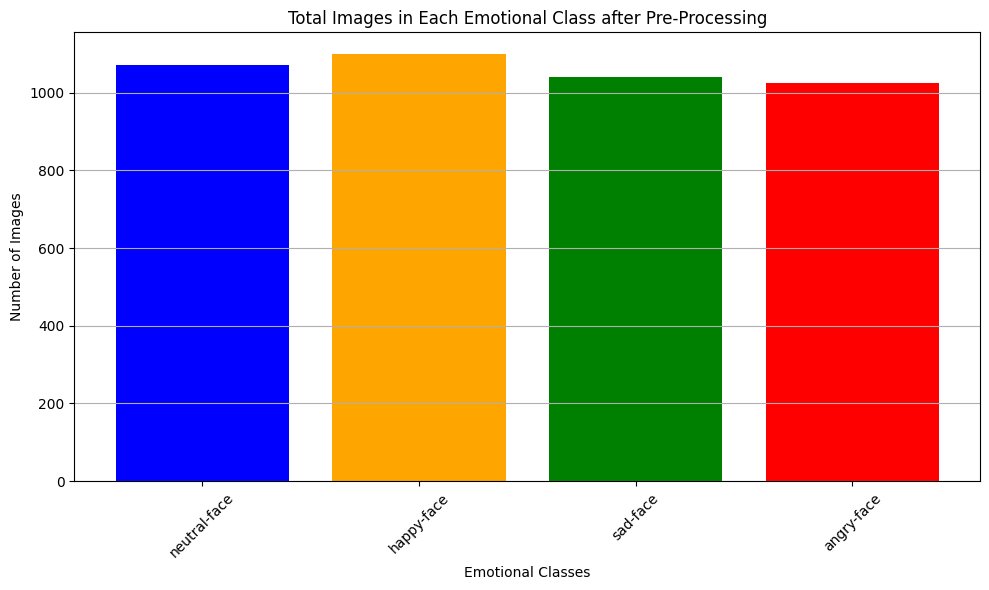

In [15]:
# Plotting the class balance after pre-processing and facial landmark detection
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Total Images in Each Emotional Class after Pre-Processing')
plt.xlabel('Emotional Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')


plt.tight_layout()
plt.show()

### Make the Training and Validation set for training
I experimented with how to best split my dataset into train and validation sets, while maintaining the directory structure. I tried manually doing so, then using 'random_state= 42' as used in the class workbook which split data in a deterministic way. (See https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-3-CNNs-and-image-classification).

In [18]:
# Code debugged with GPT
dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'
output_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split'
train_ratio = 0.8

# Create output directories for train and validation sets
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'validation')
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Dictionary to hold file paths by emotion class
class_files = {}

# Collect image and label files by emotion class
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.txt'):
            class_name = os.path.basename(root)
            if class_name not in class_files:
                class_files[class_name] = {'images': [], 'labels': []}
            file_path = os.path.join(root, f)
            if f.endswith('.jpg') or f.endswith('.png'):
                class_files[class_name]['images'].append(file_path)
            elif f.endswith('.txt'):
                class_files[class_name]['labels'].append(file_path)

# Perform train-test split for each class separately and copy the files
for class_name, files in class_files.items():
    train_image_files, val_image_files = train_test_split(files['images'], test_size=1 - train_ratio, random_state=42)
    train_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in train_image_files]
    val_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in val_image_files]

    # Copy training image and label files to the appropriate directory
    for train_image_file in train_image_files:
        relative_dir = os.path.relpath(os.path.dirname(train_image_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_image_file, os.path.join(target_dir, os.path.basename(train_image_file)))

    for train_label_file in train_label_files:
        relative_dir = os.path.relpath(os.path.dirname(train_label_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_label_file, os.path.join(target_dir, os.path.basename(train_label_file)))

    # Copy validation image and label files to the appropriate directory
    for val_image_file in val_image_files:
        relative_dir = os.path.relpath(os.path.dirname(val_image_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_image_file, os.path.join(target_dir, os.path.basename(val_image_file)))

    for val_label_file in val_label_files:
        relative_dir = os.path.relpath(os.path.dirname(val_label_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_label_file, os.path.join(target_dir, os.path.basename(val_label_file)))

print("Data split into train and validation sets for each class.")

Data split into train and validation sets for each class.


In [19]:
# Code adapted from https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition and debugged with GPT.
# convert grayscale images into RGB to avoid inconsistencies with scraped data as the pre-trained 
train_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train'
val_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation'

# Process the training directory
for root, dirs, files in os.walk(train_dir):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            print(f"Processing image: {image_path}")

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Check if the image was successfully loaded
            if image is None:
                print(f"Failed to load image: {image_path}. Skipping...")
                continue

            # Check if the image is grayscale (1 channel) and convert to RGB (3 channels)
            if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale check
                print(f"Converting grayscale to RGB: {image_path}")
                image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to RGB
                # Save the converted RGB image, overwriting the old one
                cv2.imwrite(image_path, image_rgb)
            else:
                print(f"Image already in RGB format: {image_path}")

# Process the validation directory
for root, dirs, files in os.walk(val_dir):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            print(f"Processing image: {image_path}")

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Check if the image was successfully loaded
            if image is None:
                print(f"Failed to load image: {image_path}. Skipping...")
                continue

            # Check if the image is grayscale (1 channel) and convert to RGB (3 channels)
            if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale check
                print(f"Converting grayscale to RGB: {image_path}")
                image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to RGB
                # Save the converted RGB image, overwriting the old one
                cv2.imwrite(image_path, image_rgb)
            else:
                print(f"Image already in RGB format: {image_path}")

print("All grayscale images have been converted to RGB and saved.")


Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_370491506865098460.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_370491506865098460.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514751655987.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514751655987.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-06T002237.210_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images 

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_299630181453067042.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1038009414106399997.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1038009414106399997.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986241.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986241.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_42

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/000021.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514751656127.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514751656127.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-06T003120.019_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-06T003120.019_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_110577451475

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514751655931.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_59672763807160948.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_59672763807160948.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_7670261860207339.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_7670261860207339.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-06T0

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986393.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_12033123989658324.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_12033123989658324.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986387.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986387.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-1

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_25966135342011166.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_369928556910619824.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_369928556910619824.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_19914423346149273.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_19914423346149273.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_151997174

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/000071.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986363.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986363.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_65935582036653383.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_65935582036653383.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_602215781439846568.jpg
Image

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_255649716369030214.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_378091331218021598.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_378091331218021598.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-05T231350.390_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/images - 2020-11-05T231350.390_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_122300946126004472.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_24418022950922032.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_24418022950922032.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_73605775153337356.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_73605775153337356.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_520939881907269249.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986264.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1105774514745986264.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1022106077925061100.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_1022106077925061100.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/neutral-face/pinterest_11

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/000033.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253071809477.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253071809477.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253071193451.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253071193451.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253069576312.jpg
Image already in 

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253074518993.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253069654179.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_189151253069654179.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/000041.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/000041.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/happy-face/pinterest_348325352445495133.jpg
Image already in RGB format: /Users/nix

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/000145.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_370491506819607241.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_370491506819607241.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_319051954847624045.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_319051954847624045.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/S137_005_00000025.png
Image already in RGB format: /Users/nixi

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_644366659205693589.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/images - 2020-11-06T200543.221_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/images - 2020-11-06T200543.221_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_319051954847755604.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_319051954847755604.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_4305160456470096

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/000075.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/images - 2020-11-06T195818.739_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/images - 2020-11-06T195818.739_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/000049.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/000049.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/sad-face/pinterest_319051954856264030.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thes

libpng warning: iCCP: known incorrect sRGB profile


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/000090.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/images - 2020-11-06T000443.496_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/images - 2020-11-06T000443.496_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_140806232226877.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_140806232226877.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_37928821857266150.jpg
Image alre

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/000213.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/images - 2020-11-06T003650.711_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/images - 2020-11-06T003650.711_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_932456297835319036.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_932456297835319036.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train/angry-face/pinterest_1105774514751986920.png
Im

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_815996026250023587.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000026.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000026.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655617.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655617.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000026.jpg
Image already in 

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000052.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000046.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000046.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655851.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655851.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/000084.jpg
Image already in RGB format: /Users/nix

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514745986203.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655734.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_1105774514751655734.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_2533343534695420.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_2533343534695420.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_2181499815131294.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_21251429485847250.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_21251429485847250.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_942800503217618528.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neutral-face/pinterest_942800503217618528.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/neu

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-face/pinterest_348325352435792179.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-face/pinterest_348325352434925356.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-face/pinterest_348325352434925356.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-face/pinterest_348325352441856677.jpg
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-face/pinterest_348325352441856677.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/happy-fac

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/sad-face/pinterest_319051954847244377.jpg
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/sad-face/images - 2020-11-06T195004.693_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/sad-face/images - 2020-11-06T195004.693_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/sad-face/images - 2020-11-06T182715.566_face.png
Image already in RGB format: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation/sad-face/images - 2020-11-06T182715.566_face.png
Processing image: /Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/va

libpng warning: iCCP: known incorrect sRGB profile


In [3]:
# I had a folder called 'ipynb_checkpoints' that was considered a 7th emotional class but had no data within. This prevented the above code from working because file formats listed were not found at all.
# This seemed to be a reoccuring issue for image classification processes for other python users. This was found out at: https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/27.
# I resorted to deleting the file overall and updating the training ( below code) from  7 classes to 6 and re-running training. ( code adapted from: https://stackoverflow.com/questions/61207135/how-can-i-ignore-or-remove-ipynb-checkpoints-in-colab)
dataset_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.")

.ipynb_checkpoints directory not found.


In [4]:
# Code adapted from https://www.kaggle.com/code/akshitmadan/emotion-classification-cnn-using-keras.
picture_size = 150

folder_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/'

no_of_classes = 4 # total number of subfolders in my dataset ( each emotion)

batch_size = 300
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(os.path.join(folder_path, "train"),
                                              target_size=(picture_size, picture_size),
                                              color_mode="rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(os.path.join(folder_path, "validation"),
                                           target_size=(picture_size, picture_size),
                                           color_mode="rgb",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 3587 images belonging to 4 classes.
Found 1115 images belonging to 4 classes.


### Train validation and training image transforms
This includes data augmentation using PyTorch and ImageDataGenerator from Kera, which are useful in creating variations in the image data. The following code has also been adapted from class week 3 CNN notebook as stated above.


Shape of train_numpy: (64, 150, 150, 3)


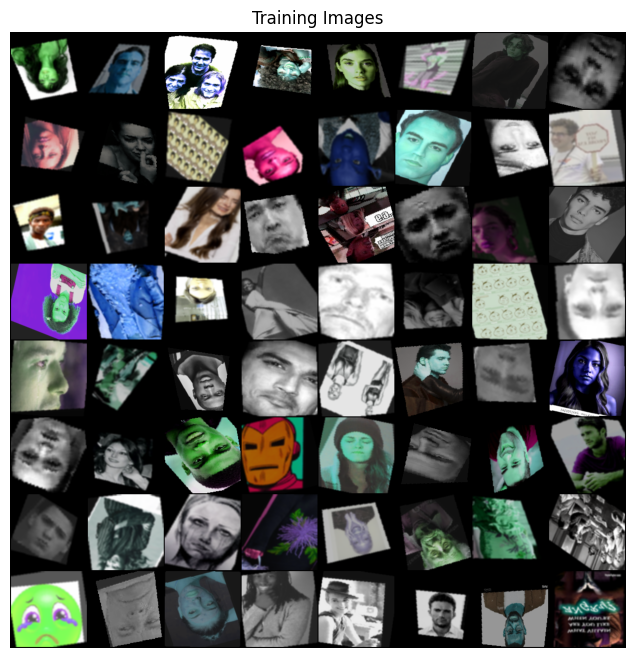

In [5]:
# Define train_transform for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Experimented with new transforms (Gaussian Blur. code adapted from https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html)
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your training dataset
train_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train'

# Load the training dataset
train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)

# Define DataLoader for batch loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Get a batch of training images
real_batch = next(iter(train_loader))
tensor_batch = real_batch[0]

# Convert a batch of PyTorch tensors to NumPy arrays
# Convert PyTorch tensors to NumPy arrays (had to convert PyTorch tensor to NumPy array, due to incorrect data processing.
# I used code adapted from: https://www.geeksforgeeks.org/how-to-convert-pytorch-tensor-to-numpy-array/ then debugged with GPT after my own attempt.

train_numpy = tensor_batch.numpy()
train_numpy = np.moveaxis(train_numpy, 1, -1)
print("Shape of train_numpy:", train_numpy.shape)

# Plot some training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Display the grid of images 
# The below code was adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t, which explained the same issue where matplotlib was not displaying my images because of image sizing differences.
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

Shape of val_numpy: (1115, 150, 150, 3)


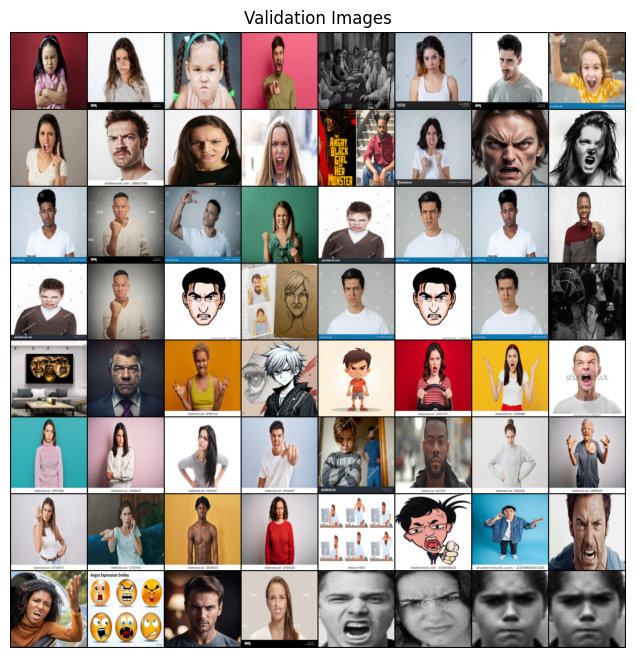

In [7]:
# Validation image transforms using the similar approach as train
import torchvision.datasets as datasets

val_transform = transforms.Compose([
    torchvision.transforms.Resize((150, 150)), 
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your validation dataset
val_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation'  # Path to the directory containing class directories

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=val_transform)

# Convert to NumPy array for data processing ( same as the above training data)
# I had an issue with the dimensions of my images
val_numpy = np.array([x.numpy() for x, _ in val_set])

# Code adapted from: https://stackoverflow.com/questions/57438392/rearranging-axes-in-numpy after an error with the shape of val_numpy (374, 1, 150, 150).
    # The error: 'sequential_9". I have an error 'ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 150, 150, 1), found shape=(None, 1, 150, 150)'
val_numpy = np.moveaxis(val_numpy, 1, -1)
print("Shape of val_numpy:", val_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Get a batch of validation images
real_batch = next(iter(val_loader))

# Convert torch tensor to numpy array and permute the dimensions to match (batch_size, height, width, channels)
tensor_batch = real_batch[0]

# Plot some validation images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")

# The code below displays the batch of images using matplotlib
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

### Define and Train Model

In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.Grayscale(),          # Convert to grayscale if needed
    transforms.ToTensor(),           # Convert to tensor
])

# Define the dataset
train_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train', transform=transform)
val_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation', transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Convert DataLoader to NumPy arrays for training and validation sets
train_numpy = []
train_labels = []

for data, labels in train_loader:
    data = data.numpy().transpose(0, 2, 3, 1)  # Convert to (batch_size, height, width, channels)
    train_numpy.append(data)
    train_labels.extend(labels.numpy().flatten())

train_numpy = np.concatenate(train_numpy, axis=0)
train_labels = np.array(train_labels)

print("Train set converted!")
print("Train numpy shape:", train_numpy.shape)
print("Train labels shape:", train_labels.shape)

# Repeat for validation set
val_numpy = []
val_labels = []

for data, labels in val_loader:
    data = data.numpy().transpose(0, 2, 3, 1)
    val_numpy.append(data)
    val_labels.extend(labels.numpy().flatten())

val_numpy = np.concatenate(val_numpy, axis=0)
val_labels = np.array(val_labels)

print("Validation set converted!")
print("Validation numpy shape:", val_numpy.shape)
print("Validation labels shape:", val_labels.shape)

Train set converted!
Train numpy shape: (3587, 150, 150, 1)
Train labels shape: (3587,)
Validation set converted!
Validation numpy shape: (1115, 150, 150, 1)
Validation labels shape: (1115,)


In [19]:
# Convert grayscale (1 channel) to RGB (3 channels)
train_numpy_rgb = np.repeat(train_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times
val_numpy_rgb = np.repeat(val_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times

train_labels_categorical = to_categorical(train_labels, num_classes=4)  
val_labels_categorical = to_categorical(val_labels, num_classes=4)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Ensure shapes are correct for EfficientNetB0 input
print("Train numpy RGB shape:", train_numpy_rgb.shape)  # Should be (3123, 150, 150, 3)
print("Validation numpy RGB shape:", val_numpy_rgb.shape)  # Should be (783, 150, 150, 3)


Train numpy RGB shape: (3587, 150, 150, 3)
Validation numpy RGB shape: (1115, 150, 150, 3)


Train numpy RGB shape: (3587, 150, 150, 3)
Validation numpy RGB shape: (1115, 150, 150, 3)
Training with frozen EfficientNetB0 base model...
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 118s 937ms/step - accuracy: 0.3155 - loss: 1.9023 - val_accuracy: 0.3076 - val_loss: 1.7328 - learning_rate: 0.0010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 112s 994ms/step - accuracy: 0.4016 - loss: 1.7045 - val_accuracy: 0.3076 - val_loss: 1.7886 - learning_rate: 0.0010
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5162 - loss: 1.4540 - val_accuracy: 0.3094 - val_loss: 1.9291 - learning_rate: 0.0010
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 110s 975ms/step - accuracy: 0.6039 - loss: 1.2632 - val_accuracy: 0.3103 - val_loss: 1.7752 - learning_rate: 0.0010
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6768 - loss: 1.1514 - val_accuracy: 0.3283 - val_loss: 1.8137 - learning_rate: 0.0010
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7104 - loss: 1.068

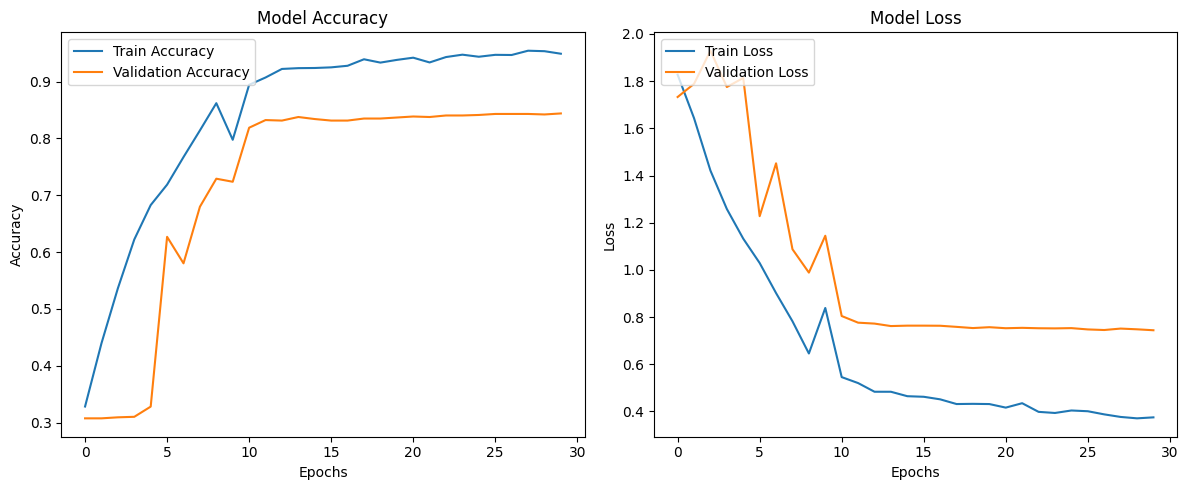

In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.Grayscale(),          # Convert to grayscale if needed
    transforms.ToTensor(),           # Convert to tensor
])

# Define the dataset
train_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train', transform=transform)
val_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation', transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Convert DataLoader to NumPy arrays for training and validation sets
def convert_to_numpy(loader):
    data_list = []
    labels_list = []
    for data, labels in loader:
        data = data.numpy().transpose(0, 2, 3, 1)  # Convert to (batch_size, height, width, channels)
        data_list.append(data)
        labels_list.extend(labels.numpy().flatten())
    data_numpy = np.concatenate(data_list, axis=0)
    labels_numpy = np.array(labels_list)
    return data_numpy, labels_numpy

train_numpy, train_labels = convert_to_numpy(train_loader)
val_numpy, val_labels = convert_to_numpy(val_loader)

# Convert grayscale (1 channel) to RGB (3 channels)
train_numpy_rgb = np.repeat(train_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times
val_numpy_rgb = np.repeat(val_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times

# One-hot encode the labels
num_classes = 4  # Update this to match the number of classes in your dataset
train_labels_categorical = to_categorical(train_labels, num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Ensure shapes are correct for EfficientNetB0 input
print("Train numpy RGB shape:", train_numpy_rgb.shape)  # Should be (3123, 150, 150, 3)
print("Validation numpy RGB shape:", val_numpy_rgb.shape)  # Should be (783, 150, 150, 3)

# Define the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # unFreeze the base model

model = Sequential([
    base_model,  # Include the EfficientNetB0 pre-trained layers with L2 regularization
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # added dropout for deeper layering that increases as the model goes on.
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    Dropout(0.4),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

# Compile the model with a higher initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    ModelCheckpoint("model_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

# Train the model with the frozen EfficientNetB0 base
print("Training with frozen EfficientNetB0 base model...")
history_frozen = model.fit(
    train_numpy_rgb,  # Training images in RGB format
    train_labels_categorical,  # Training labels
    validation_data=(val_numpy_rgb, val_labels_categorical),  # Correct validation images and labels
    class_weight=class_weight_dict,  # uses class weights computed above
    epochs=10,  # increased epochs
    callbacks=callbacks_list
)

# Fine-tune some EfficientNetB0 layers
print("Fine-tuning the EfficientNetB0 model...")
base_model.trainable = True  # Unfreeze the base model

# Freeze all but the last few layers of EfficientNetB0
for layer in base_model.layers[:-90]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_unfrozen = model.fit(
    train_numpy_rgb,
    train_labels_categorical,
    validation_data=(val_numpy_rgb, val_labels_categorical),
    class_weight=class_weight_dict,
    epochs=20,
    callbacks=callbacks_list
)

# Combine the histories
history = {}
for k in history_frozen.history.keys():
    history[k] = history_frozen.history[k] + history_unfrozen.history[k]

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Alternative Model Training

Training with frozen EfficientNetB0 base model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.2327 - loss: 2.1703 - val_accuracy: 0.1910 - val_loss: 1.8561 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.2636 - loss: 1.9749 - val_accuracy: 0.1928 - val_loss: 1.7955 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.2530 - loss: 1.9012 - val_accuracy: 0.3085 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 217ms/step - accuracy: 0.2397 - loss: 1.8231 - val_accuracy: 0.3085 - val_loss: 1.6668 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.2516 - loss: 1.7758 - val_accuracy: 0.3076 - val_loss: 1.6579 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.2509 - loss: 1.7285 - val_accuracy: 0.1812 - val_loss: 1.6653 - learning_rate: 0.0010
Epoch 7/100
11

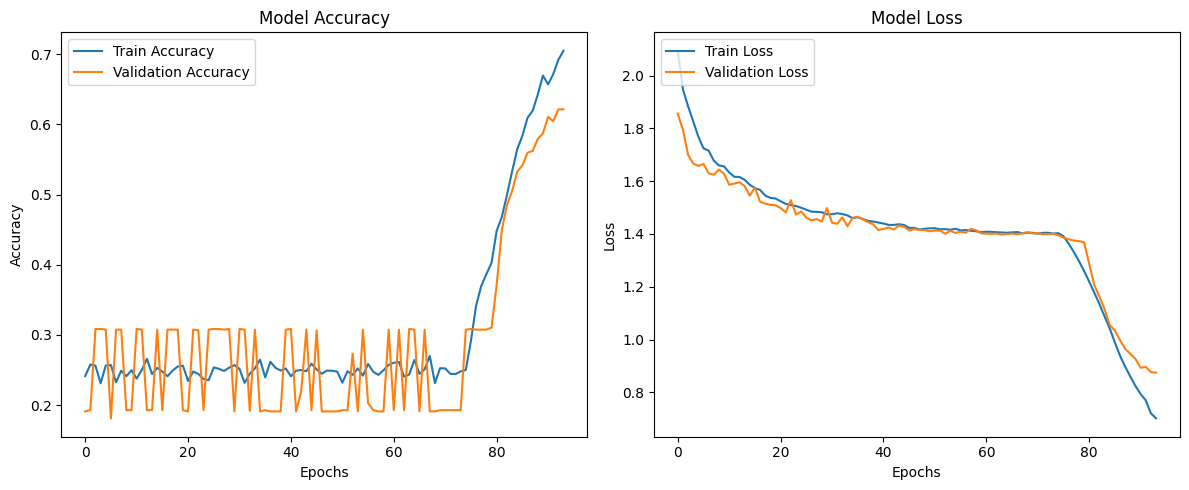

In [13]:
# Code adapted from: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7 and debugged with GPT for resampling issues.
# I ran into a 'ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>' which suggested my data for the training and validation were not in an expected format before passing them into the model.fit() function
# The next two lines of code were suggested by GPT, converting PyTorch dataset to MumPy arrays, which then can be used with Keras.

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# VGG16 base model
model = Sequential([
    base_model,  # Include the EfficientNetB0 pre-trained layers with L2 regularization
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # added dropout for deeper layering that increases as the model goes on.
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    Dropout(0.4),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation(swish),  # Use swish activation
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


# Compile the model with a higher initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    ModelCheckpoint("model_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)]

#Train the model with the frozen EfficientNetB0 base
print("Training with frozen EfficientNetB0 base model...")
history_frozen = model.fit(
    train_numpy_rgb,  # Training images in RGB format
    train_labels_categorical,  # Training labels
    validation_data=(val_numpy_rgb, val_labels_categorical),  # Correct validation images and labels
    class_weight=class_weight_dict, # uses class weights computed above
    epochs=100, # increased epochs
    callbacks=callbacks_list)

# Fine-tune some EfficientNetB0 layers
print("Fine-tuning the EfficientNetB0 model...")
base_model.trainable = True  # Unfreeze the base model

# Freeze all but the last few layers of EfficientNetB0
for layer in base_model.layers[:-10]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_unfrozen = model.fit(
    train_numpy_rgb,
    train_labels_categorical,
    validation_data=(val_numpy_rgb, val_labels_categorical),
    class_weight=class_weight_dict,
    epochs=20,
    callbacks=callbacks_list)


# Combine the histories
history = {}
for k in history_frozen.history.keys():
    history[k] = history_frozen.history[k] + history_unfrozen.history[k]

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

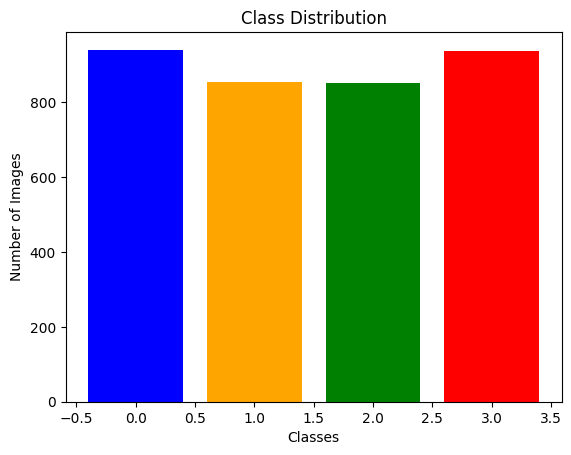

In [21]:
# Analyse the distribution of data for each emotional class
unique, counts = np.unique(train_labels, return_counts=True)
colors = ['blue', 'orange', 'green', 'red'] # added color=['blue', 'orange', 'green', 'red'] to correspond with the classes throughout

plt.bar(unique, counts, color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

In [29]:
model.save_weights("model_h5_weights.weights.h5") # Save model

In [30]:
# Save the entire model
model.save("model.h5")

### Plotting Accuracy
Code adapted from: https://www.askpython.com/python/examples/print-a-percentage-value-in-python

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step
Shape of true_labels: (1115,)
First few true labels: [0 0 0 0 0]
Shape of predicted_labels: (1115,)
First few predicted labels: [0 0 0 0 0]


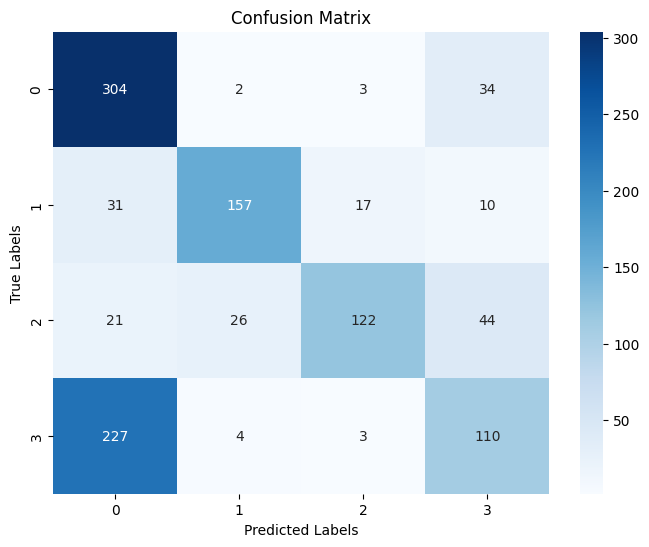

In [14]:
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make Prediction
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

#Convert Predictions and True Labels
true_labels = np.argmax(val_labels_categorical, axis=1)  

print("Shape of true_labels:", true_labels.shape)
print("First few true labels:", true_labels[:5])
print("Shape of predicted_labels:", predicted_labels.shape)
print("First few predicted labels:", predicted_labels[:5])

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,657,929 (52.10 MB)

 Trainable params: 4,538,144 (17.31 MB)

 Non-trainable params: 43,495 (169.91 KB)

 Optimizer params: 9,076,290 (34.62 MB)

In [18]:
# Get model weights 
# Choose the weight most accurate
weights = model.get_weights() 
print(weights)

[array([0.485, 0.456, 0.406], dtype=float32), array([0.229, 0.224, 0.225], dtype=float32), 0, array([[[[ 2.08580531e-02,  8.54183197e-01, -9.72631514e-01,
           5.79903126e-01,  3.34148332e-02, -1.69484597e-02,
          -1.26327090e-02,  6.05713241e-02, -7.40817130e-01,
          -2.29851604e-01,  2.01381966e-01, -2.29513887e-02,
          -3.81937772e-01, -1.13323188e+00, -4.95665856e-02,
          -5.28731287e-01,  5.95421717e-02,  3.28112692e-01,
           7.25743413e-01,  9.55608115e-02,  4.34162794e-03,
           7.98940003e-01,  1.60865933e-01,  1.49564901e-02,
           2.18159467e-01, -6.15012765e-01,  7.50642642e-02,
           3.51907797e-02, -9.52915826e-08, -6.25985712e-02,
           2.34308150e-02, -1.42679662e-01],
         [ 1.29814260e-02,  1.56631804e+00, -1.80512953e+00,
           7.77627707e-01,  6.73766211e-02,  2.09946394e-01,
          -8.78881961e-02, -3.77111018e-01,  5.81170559e-01,
          -3.46002936e-01,  6.97611496e-02, -8.75761881e-02,
       

25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 682ms/step
Shape of true_labels: (783,)
First few true labels: [0 0 0 0 0]
Shape of predicted_labels: (783,)
First few predicted labels: [0 0 0 0 0]


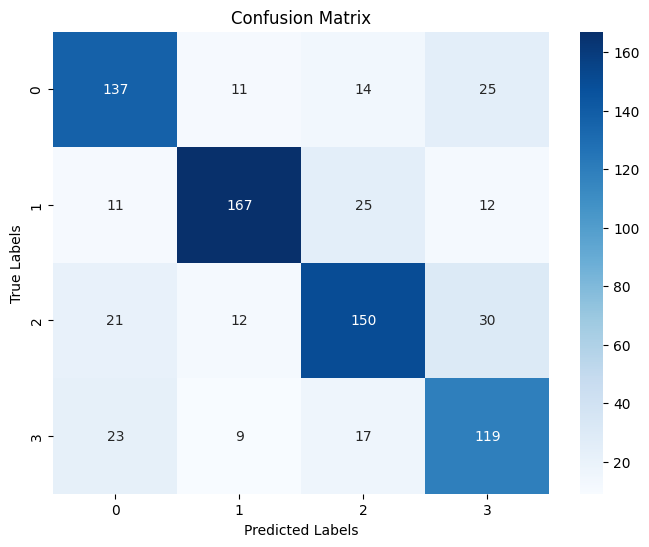

In [12]:
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make Prediction
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

#Convert Predictions and True Labels
true_labels = np.argmax(val_labels_categorical, axis=1)  

print("Shape of true_labels:", true_labels.shape)
print("First few true labels:", true_labels[:5])
print("Shape of predicted_labels:", predicted_labels.shape)
print("First few predicted labels:", predicted_labels[:5])

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### What are my emotional classes?
Finding out which emotional class labels correspond to which emotion in my directory ( stored as one-hot) as made by ImageFolder.

In [7]:
# Code adapted using https://discuss.pytorch.org/t/how-to-get-the-class-names-to-class-label-mapping/470 and GPT for debugging.
import torchvision.datasets as datasets

# Print class info. Code adapted from: https://stackoverflow.com/questions/54734286/how-to-get-class-to-idx-map-for-custom-dataset-in-pytorch
for class_name, class_index in sorted(train_set.class_to_idx.items()):
    print(class_name,class_index)

angry-face 0
happy-face 1
neutral-face 2
sad-face 3


###  Model evaluation
Code adapted from: https://www.tutorialspoint.com/deep_learning_with_keras/deep_learning_with_keras_evaluating_model_performance.htm

In [15]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1496 - loss: 975522.0625 
Test Loss: 854452.5625
Test Accuracy: 0.20000000298023224


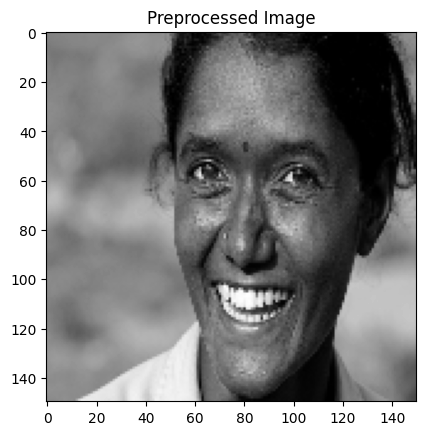

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class Label: happy-face
ExpectedClass Label : happy


In [33]:
import tensorflow as tf
import cv2

# Dowload a new image for classification and test the model to see the classification progress. 
# Code adapted from: https://github.com/MahdiNavaei/Emotion-Classification-with-CNN/blob/main/projrct.ipynb.
# I chose a happy face because the model seemed to always classify this emotion best and thus should be the quickest way to identify if the model works overall.

img=cv2.imread('new-image1.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# resize and add in grayscale to match the train and validation images
resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='grey')
plt.title("Preprocessed Image")
plt.show()

#Load in model and image details to see which emotional class is predicted.
# Code also adapted from: https://www.tensorflow.org/tutorials/keras/save_and_load

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)
print ("ExpectedClass Label : happy")

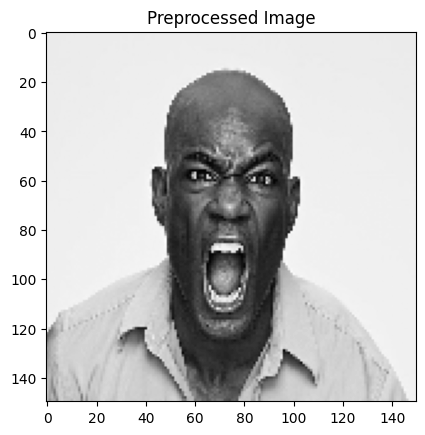

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class Label: angry-face
ExpectedClass Label : angry


In [20]:
# What about other emotional classes e.g., anger
img=cv2.imread('new_image2.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)
print ("ExpectedClass Label : angry")



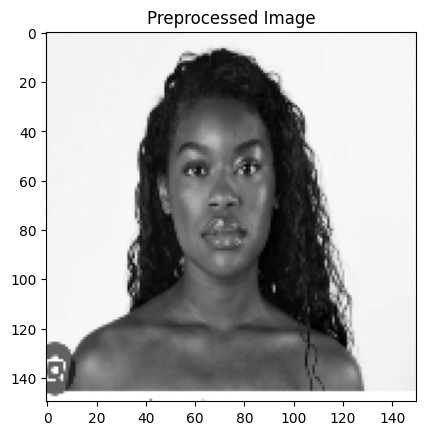

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Predicted Class Label: neutral-face
ExpectedClass Label : neutral


In [34]:
# What about other emotional classes e.g., neutral
img=cv2.imread('new_image3.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)
print ("ExpectedClass Label : neutral")
 

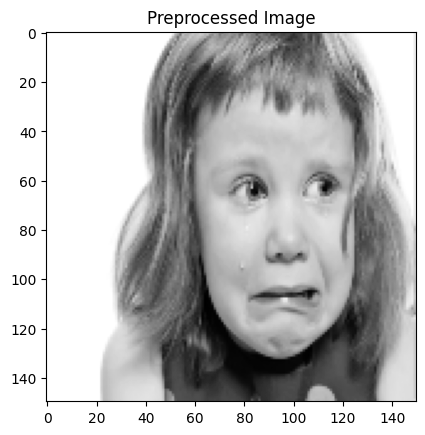

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class Label: sad-face
ExpectedClass Label : sad


In [37]:
# What about other emotional classes e.g., sad
img=cv2.imread('new_image4.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'happy-face', 'neutral-face', 'sad-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)
print ("ExpectedClass Label : sad")

In [36]:
# Recompile the model if necessary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Custom Model with Skip connections 


In [ ]:
from tensorflow.keras.layers import Add, Conv2D, Input, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Input layer
input_tensor = Input(shape=(150, 150, 1))  # Assuming grayscale input

# Initial Conv2D without a skip connection
x = Conv2D(32, (3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# First block with skip connection
skip_1 = x
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
skip_1 = Conv2D(64, (1, 1), padding='same')(skip_1)
x = Add()([x, skip_1])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second block with skip connection
skip_2 = x
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
skip_2 = Conv2D(128, (1, 1), padding='same')(skip_2)
x = Add()([x, skip_2])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third block with skip connection
skip_3 = x
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
skip_3 = Conv2D(256, (1, 1), padding='same')(skip_3)
x = Add()([x, skip_3])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fourth block with skip connection
skip_4 = x
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
skip_4 = Conv2D(512, (1, 1), padding='same')(skip_4)
x = Add()([x, skip_4])
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Fully connected layers
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Output layer (4 classes)
output_tensor = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
initial_learning_rate = 0.01
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(
    train_numpy_resampled,         # Resampled training data (after SMOTE)
    train_labels_categorical_resampled,  # Categorical training labels (after SMOTE)
    validation_data=(val_numpy, val_labels_categorical),  # Validation data and labels
    epochs=20,                    # Number of epochs for training
    batch_size=32,                # Batch size for each step of training
    class_weight=class_weight_dict,  # Class weights to handle class imbalance
    verbose=1)                     # Verbosity level to display training progress


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 75, 75,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 37, 37,    │          0 │ batch_normalizat

 Total params: 9,215,492 (35.15 MB)

 Trainable params: 9,210,052 (35.13 MB)

 Non-trainable params: 5,440 (21.25 KB)

NameError: name 'train_labels_categorical_resampled' is not defined